In [1]:
import yfinance as yf 
import pandas as pd  
import numpy as np 

import matplotlib.pyplot as plt
# Scaling Package
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier  
from sklearn.metrics import accuracy_score


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import SGD
# Set Random seed     
import random
random.seed(2505)

In [ ]:
df = pd.read_csv('Apple_Stock.csv') 
print(df.shape) 
df.head()

In [5]:
x = df.values #returns a numpy array 

min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df2 = pd.DataFrame(x_scaled)

In [6]:
df = df2 
df2.columns = column_names 
df2.head()

,Open,High,Low,Close
0,0.038886,0.039521,0.041534,0.045284
1,0.042723,0.043167,0.045997,0.045235
2,0.042739,0.041417,0.046196,0.046532
3,0.044196,0.044495,0.047799,0.049726
4,0.045669,0.044884,0.049253,0.048672


In [7]:
# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 30 # Number of samples (in past)
steps = 1 # Number of steps (in future)
X = [] # X array
Y = [] # Y array
for i in range(df2.shape[0] - samples):
    X.append(df2.iloc[i:i+samples, 0:3].values) # Independent Samples
    Y.append(df2.iloc[i+samples, 3:].values) # Dependent Samples
print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(Y[0:1]),': ', Y[0:1])

Training Data: Length is  60 :  [array([[0.03888562, 0.03952097, 0.04153423],
       [0.04272274, 0.04316659, 0.04599719],
       [0.04273892, 0.04141674, 0.04619554],
       [0.044196  , 0.04449513, 0.04779882],
       [0.04566932, 0.04488401, 0.04925338],
       [0.04599308, 0.04399286, 0.04839386],
       [0.04374271, 0.04276152, 0.04771619],
       [0.04605788, 0.04468961, 0.05017905],
       [0.04863208, 0.04771943, 0.05209639],
       [0.05141678, 0.05100852, 0.05290635],
       [0.04858345, 0.0507816 , 0.05113766],
       [0.05379674, 0.05215893, 0.05639401],
       [0.05256621, 0.0513163 , 0.05500547],
       [0.05044535, 0.0483999 , 0.05366664],
       [0.05044532, 0.05108946, 0.05403026],
       [0.05036438, 0.04762218, 0.04804674],
       [0.04592831, 0.04381463, 0.04363349],
       [0.04186467, 0.03903499, 0.04285666],
       [0.03888576, 0.03605381, 0.03791453],
       [0.03138974, 0.03153331, 0.03399709],
       [0.03355918, 0.03326695, 0.0369723 ],
       [0.03404482, 0.

In [8]:
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

Dimensions of X (1295, 60, 3) Dimensions of Y (1295, 1)


In [9]:
# # Get the training and testing set
threshold = round(0.9 * X.shape[0])
trainX, trainY = X[:threshold], Y[:threshold]
testX, testY =  X[threshold:], Y[threshold:]
print('Training Length',trainX.shape, trainY.shape,'Testing Length:',testX.shape, testY.shape)

Training Length (1166, 60, 3) (1166, 1) Testing Length: (129, 60, 3) (129, 1)


In [10]:
model = Sequential()
    # First GRU layer with Dropout regularisation
model.add(GRU(units=50, return_sequences=True, input_shape=(X.shape[1],X.shape[2]), activation='tanh'))
model.add(Dropout(0.2)) 

    # Second GRU layer
model.add(GRU(units=50, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
    
    # Third GRU layer
model.add(GRU(units=50, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2)) 

    # Fourth GRU layer
model.add(GRU(units=50, activation='tanh'))
model.add(Dropout(0.2)) 

    # The output layer
model.add(Dense(units=2))  


model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')


2023-05-19 14:54:21.833439: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
history = model.fit(trainX,
                    trainY,
                    shuffle = False, # Since this is time series data
                    epochs=30,
                    batch_size=150,
                    validation_split=0.2,
                    verbose=0)

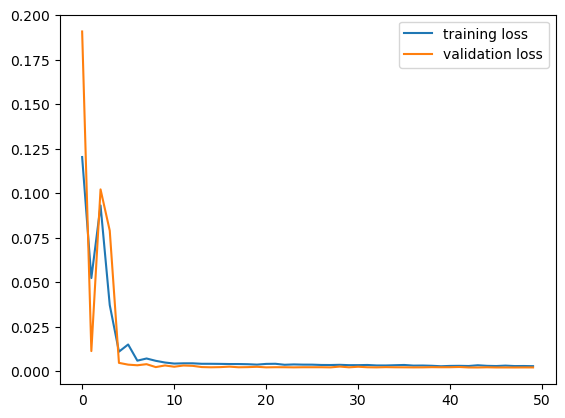

In [12]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()

5/5 [==============================] - 1s 12ms/step


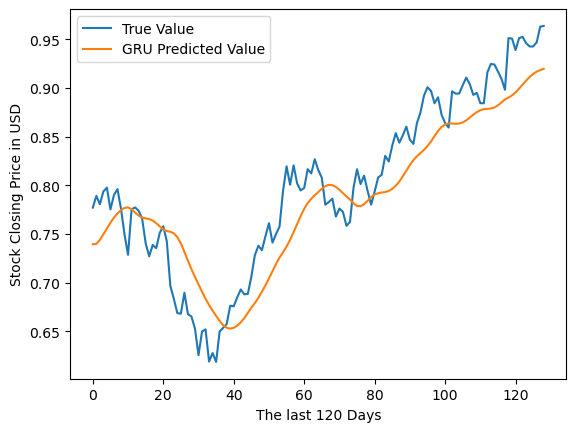

In [13]:
y_pred = model.predict(testX)
plt.plot(testY, label = 'True Value')   
plt.plot(y_pred[:,0],label='GRU Predicted Value')  
plt.xlabel("The last 120 Days") 
plt.ylabel("Stock Closing Price in USD")
plt.legend()

In [19]:
print(y_pred.shape) 

(129, 2)


In [20]:
print(testY.shape)

(129, 1)


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
# Compute evaluation metrics
output_index = 0  # Index of the output column to evaluate
mse = mean_squared_error(testY, y_pred[:, output_index])
mae = mean_absolute_error(testY, y_pred[:, output_index])
r2 = r2_score(testY, y_pred[:, output_index])

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score (R2):", r2)

Mean Squared Error (MSE): 0.0014115739227878535
Mean Absolute Error (MAE): 0.03289421558796041
R-squared Score (R2): 0.8232595389294134
